### 文档扫描

使用opencv对图片中的文字进行识别扫描的例子

In [1]:
from PIL import Image
import pytesseract
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("success!")

success!


In [2]:
#matplotlib显示图像
def showImage(image,gray=None):
    if gray is None:
        imageplt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(imageplt)
    else:
        plt.imshow(image,'gray')

In [3]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dsize = None
    (srcH,srcW) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        ratio = height / float(srcH)
        dsize = (int(srcW * ratio), height)
    else:
        ratio = width / float(srcW)
        dsize = (width, int(srcW * ratio))
    dst = cv2.resize(image, dsize, interpolation=inter)
    return dst

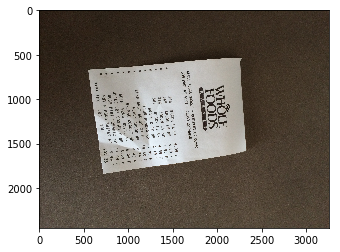

In [4]:
# 读取输入图像
image = cv2.imread('./images/receipt.jpg')
showImage(image)

我们要识别文字区域，首先可以用边缘检测，确定出文字的区域的边缘。然后使用轮廓检测来找到这个文字区域的边缘框。

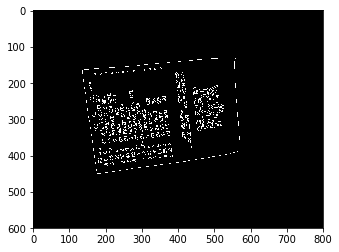

In [5]:
#对图片进行resize，原图太大影响效率，我们需要的图片size够我们识别文字信息就足够了
#保留缩放比例因子，是因为我们扫描出文字区域后，还要回归到我们原始尺寸，需要这个缩放因子来转换我们resize图片的坐标
ratio = image.shape[0] / 600.0
copyImg = image.copy()

copyImg = resize(copyImg, height = 600)

# 预处理，做一次高斯模糊和边缘检测，来确定文字区域的边缘
grayImg = cv2.cvtColor(copyImg, cv2.COLOR_BGR2GRAY)
grayImg = cv2.GaussianBlur(grayImg, (5, 5), 0)
edgedImg = cv2.Canny(grayImg, 75, 200)
showImage(edgedImg,'gray')

In [58]:
print(copyImg.shape)
print(image.shape)

(600, 800, 3)
(2448, 3264, 3)


从图中我们看到经过边缘检测，可以得到文字最外层的边缘信息，我们再使用轮廓检测，得到最外层的文字轮廓。
最外层的轮廓就是所有轮廓面积中最大的那个。然后我们再得到这个最大轮廓的近似多边形，调成阈值，使这个近似多边形是一个四边形这里要引起注意，这里是4边形框，不是矩形框，矩形是4边形，但4边形不一定是矩形。

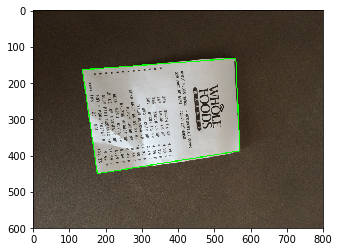

In [6]:
# 轮廓检测
cnts = cv2.findContours(edgedImg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
#这里最大的轮廓就是包裹整个文字区域的边框
maxcnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
peri = cv2.arcLength(maxcnt, True)
approxRect = cv2.approxPolyDP(maxcnt, 0.02 * peri, True)#调成阈值。得到近似四边形。0.02 * peri是不停调整得到的
cv2.drawContours(copyImg, [approxRect], -1, (0, 255, 0), 2)
showImage(copyImg)

我们就过滤掉了其它元素，得到包裹文字的四边形形框，即是图片绿色标注出来的。在这里图片是可以任意角度拍摄的，所以这里的文字是倾斜的。我们希望可以将这些文字摆正，也就是我们可以正常阅读的方向，这就需要我们做一个投影变换。我们一步一步来分析这个过程。我们先打印出得到的绿色框的四个坐标，我们发现这些坐标很顺序是打乱的。我们希望得到一个有左到右顺时针的顺序，即是左上，右上，右下，左下这样的顺序。

In [15]:
print(approxRect.reshape(4, 2))
print(approxRect.shape)

[[559 132]
 [136 164]
 [177 450]
 [570 387]]
(4, 1, 2)


我们如何得到从approxRect4边形框中知道谁是左上，右上，右下，左下这四个点呢。我们先考虑左上和右上，他们肯定是y值最小的两个，它俩之间x较小的是左上，x较大的是右上。这两个确定后，另外两个就是左下和右下。同理这两个x较小的是左下，x较大的是右下。

In [7]:
import operator
def clockwiseOrder(pts):
    # 一共4个坐标点
    rect = np.zeros((4, 2), dtype = "float32")

    # 按顺序找到对应坐标，分别是 左上，右上，右下，左下
    
    #先对y坐标进行升序排列,如果y相同，则按照x大小排序
    pts = sorted(pts, key=operator.itemgetter(1,0))
    #根据x大小确定谁是左上和右上
    if pts[0][0] < pts[1][0]:
        rect[0] = pts[0]
        rect[1] = pts[1]
    else:
        rect[0] = pts[1]
        rect[1] = pts[0]
    #根据x大小确定谁是左下和右下   
    if pts[2][0] < pts[3][0]:
        rect[2] = pts[3]
        rect[3] = pts[2]
    else:
        rect[2] = pts[2]
        rect[3] = pts[3] 

    return rect

In [42]:
#这里要对原图做转换，所以用到了我们之前的ratio比例因子，乘上该因子将坐标换算到原图的大小
rect = clockwiseOrder(approxRect.reshape(4, 2) * ratio)
(tl, tr, br, bl) = rect
print((tl, tr, br, bl))

(array([136., 164.], dtype=float32), array([559., 132.], dtype=float32), array([570., 387.], dtype=float32), array([177., 450.], dtype=float32))


经过clockwiseOrder方法得到了按照左上，右上，右下，左下的顺序的坐标，打印结果表明结果是正确的。为了让文字按照书本的顺序显示，现在我们就根据这四个坐标来进行投影变换。注意要将文字顺序调整正确，我们得知道原始图片文字的方向

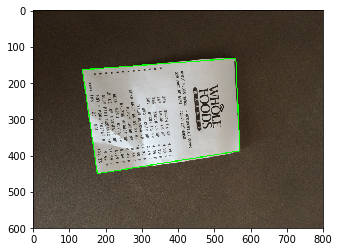

In [43]:
showImage(image)

我们再看下原图，文字是朝着右边倒着的，此时我们根据clockwiseOrder方法得到的4个点，如果要让文字正常方向显示，那么映射关系就是：
原右上点 : 坐标原点[0,0]，
原左上点 : 左下点，
原左下点 ：右下点，
原右下点 ：右上点

In [8]:
def perspectiveTransform(image, pts):
    # 按顺序找到对应坐标
    rect = clockwiseOrder(pts)
    #分别对应左上，右上，右下，左下
    (tl, tr, br, bl) = rect

    #计算输入的w和h值，之所以要这么计算，就因为这个4边形不一定是矩形
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    #变换后对应坐标位置，要让文字正常顺序显示
    dst = np.array([
        [0, maxWidth - 1],
        [0, 0],
        [maxHeight - 1, 0],
        [maxHeight - 1, maxWidth - 1]], dtype = "float32")   

    #计算变换矩阵
    persM = cv2.getPerspectiveTransform(rect, dst)
    transImg = cv2.warpPerspective(image, persM, (maxHeight,maxWidth))

    #返回变换后结果
    return transImg

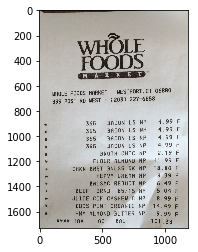

In [9]:
# 透视变换
tansFormImg = perspectiveTransform(image, approxRect.reshape(4, 2) * ratio)
showImage(tansFormImg)

关于如何利用4个点坐标得到投影变换矩阵的，可以到我的github上看我写的一篇文章，叫Opencv的getPerspectiveTransform方法如何获取投影转换矩阵，文章里有关于求解的数学推导。链接地址为：https://github.com/zhangjiqiang/AIProject/tree/master/%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E7%9A%84%E7%9B%B8%E5%85%B3%E6%8A%80%E6%9C%AF%E6%96%87%E7%AB%A0

经过我们的变换置换后，我们把倾斜的文字方向调整为正常方向了。然后我们可以使用pytesseract库做文档扫描识别了。

In [10]:
#保存转换后的文件
tansFormImg = cv2.cvtColor(tansFormImg, cv2.COLOR_BGR2GRAY)
tansFormImg = cv2.threshold(tansFormImg, 100, 255, cv2.THRESH_BINARY)[1]
cv2.imwrite('document.jpg', tansFormImg)

True

In [11]:
#使用pytesseract库做文档扫描
text = pytesseract.image_to_string(Image.open('document.jpg'))
print(text)

we ose wk owe wk we owe wk we wk ok o %o %

 

WHOLE
FOODS
"M _A _E TJ

WHOLE FOODS MARKET - wWESTPORT,CT 06880
399 POST RD WEST - (203) 227-6858

365 BACON LS

365 BACON LS

365 BACON LS

365 BACON LS

BROTH CHIC

FLOUR ALMOND

CHKN BRST BNLSS SK

HEAVY CREAM

BALSMC REDUCT

BEEF - GRND - 85/15

JUICE COF CASHEW L

BOCES PINT PC

HNY ALMOND BuiTeEN
% % ® # TAX 00 BRL

NP
NP
NP

n m n tom n oft t toc a n s
